# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


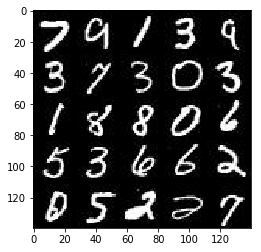

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

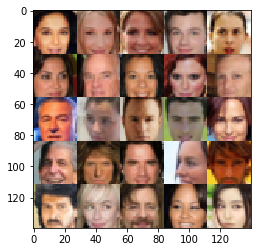

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [52]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None,z_dim), name='input_z')
    learningrate = tf.placeholder(tf.float32, None, name='learningrate')

    return input_real, input_z, learningrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [53]:
def discriminator(images, reuse=False,alpha =0.2,is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3(depth)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True,alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [87]:
def model_loss(input_real, input_z,out_channel_dim,is_train=True,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [101]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,print_every=10):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learningrate = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    #print(data_shape[-1])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                z_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: z_noise})
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise,input_real:batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: z_noise})
                    train_loss_g = g_loss.eval({input_z: z_noise})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                                  "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.8501... Generator Loss: 0.0410
Epoch 1/2... Discriminator Loss: 2.6350... Generator Loss: 2.1052
Epoch 1/2... Discriminator Loss: 3.3294... Generator Loss: 1.1537
Epoch 1/2... Discriminator Loss: 2.1013... Generator Loss: 1.4342
Epoch 1/2... Discriminator Loss: 2.4344... Generator Loss: 0.1866
Epoch 1/2... Discriminator Loss: 2.8372... Generator Loss: 0.0891
Epoch 1/2... Discriminator Loss: 3.3872... Generator Loss: 0.0662
Epoch 1/2... Discriminator Loss: 1.8574... Generator Loss: 0.4606
Epoch 1/2... Discriminator Loss: 3.5031... Generator Loss: 0.0494
Epoch 1/2... Discriminator Loss: 2.2278... Generator Loss: 0.1550


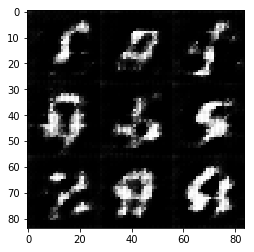

Epoch 1/2... Discriminator Loss: 1.8777... Generator Loss: 0.2314
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 2.2725... Generator Loss: 0.1464
Epoch 1/2... Discriminator Loss: 2.4270... Generator Loss: 0.1810
Epoch 1/2... Discriminator Loss: 2.2640... Generator Loss: 0.1400
Epoch 1/2... Discriminator Loss: 1.6801... Generator Loss: 0.2966
Epoch 1/2... Discriminator Loss: 1.9214... Generator Loss: 0.2650
Epoch 1/2... Discriminator Loss: 1.8409... Generator Loss: 1.6541
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 1.6043... Generator Loss: 0.3722


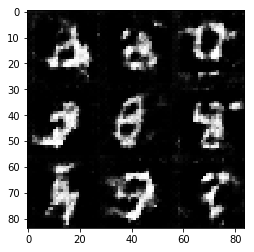

Epoch 1/2... Discriminator Loss: 1.7616... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.5155... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 0.5662
Epoch 1/2... Discriminator Loss: 1.6756... Generator Loss: 0.2965
Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.4161
Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.4897


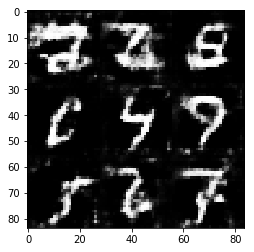

Epoch 1/2... Discriminator Loss: 1.6041... Generator Loss: 0.5704
Epoch 1/2... Discriminator Loss: 1.3962... Generator Loss: 0.6885
Epoch 1/2... Discriminator Loss: 1.6480... Generator Loss: 2.0059
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.3133
Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 1.6829
Epoch 1/2... Discriminator Loss: 1.5997... Generator Loss: 0.2978
Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.3736
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.4431
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.5464


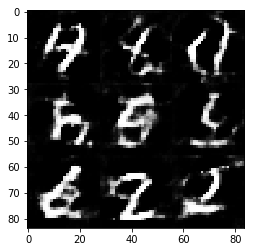

Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.8619
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 1.3315... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.5786... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 2.0243... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.2844
Epoch 1/2... Discriminator Loss: 1.5692... Generator Loss: 0.3590


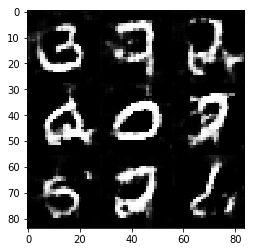

Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 1.2815
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 0.6036
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.5678... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.3773
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 1.1997
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.9970


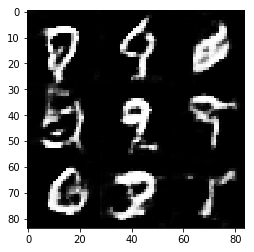

Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 1.6185... Generator Loss: 0.3656
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.6266
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 1.4535
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.5357


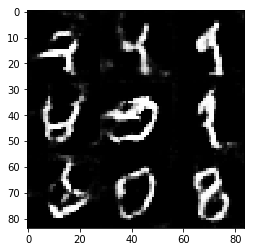

Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.3997
Epoch 1/2... Discriminator Loss: 1.6562... Generator Loss: 0.2950
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 1.3523
Epoch 1/2... Discriminator Loss: 1.3523... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 0.9915
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.3386
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.4943
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.5629
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.6030


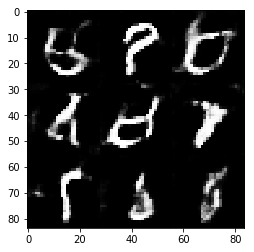

Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.2230... Generator Loss: 0.9122
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.8848
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.9306
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.4753
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.3364


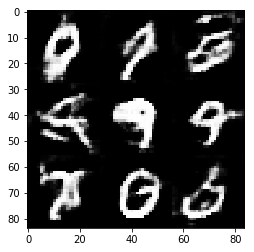

Epoch 1/2... Discriminator Loss: 1.2610... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.4105... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 1.5346... Generator Loss: 0.3301
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.0601


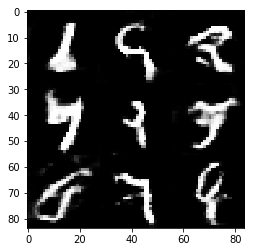

Epoch 1/2... Discriminator Loss: 1.2754... Generator Loss: 1.1556
Epoch 1/2... Discriminator Loss: 1.3401... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.5896... Generator Loss: 0.3166
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.4897
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 2.4720... Generator Loss: 2.2068
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.8547


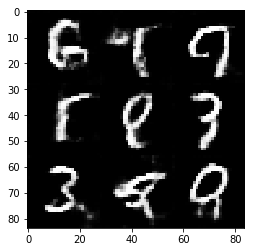

Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.7871
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 0.4868
Epoch 1/2... Discriminator Loss: 1.4931... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.4557... Generator Loss: 0.4055
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 1.0151
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.6929
Epoch 1/2... Discriminator Loss: 1.5100... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.7083


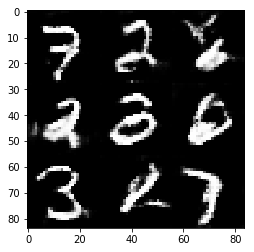

Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.3238
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.7840
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.6018
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.3851
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 1.3711


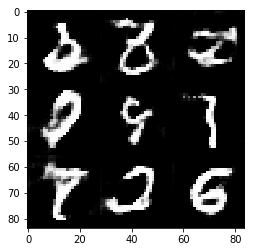

Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 2.2691
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 1.1185
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.6055
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.5360
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 2.3711
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 0.8812


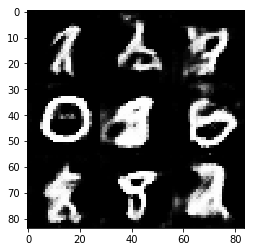

Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.7875
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.3205
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 2.2686
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.3585
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 1.2646


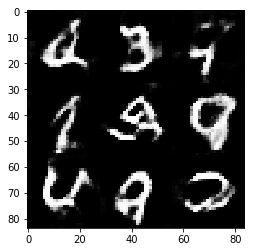

Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 1.5299
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 1.4339
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 2.3495
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.4964
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.7837


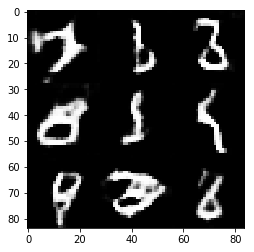

Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 1.2562
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 1.2678... Generator Loss: 0.7955


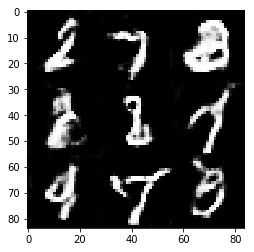

Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 1.4258
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 1.4379
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.3920
Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.5810
Epoch 1/2... Discriminator Loss: 0.7200... Generator Loss: 1.6951
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 1.1825


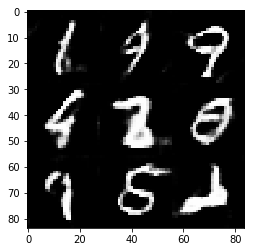

Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.8620
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 1.6819
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.0708
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 0.7247... Generator Loss: 1.1033


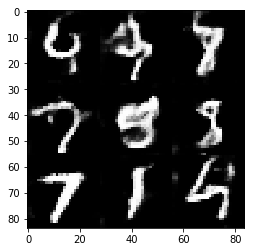

Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 2.5803
Epoch 2/2... Discriminator Loss: 1.1659... Generator Loss: 2.1737
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 0.8956... Generator Loss: 1.1833
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.7800
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.0012... Generator Loss: 0.8373


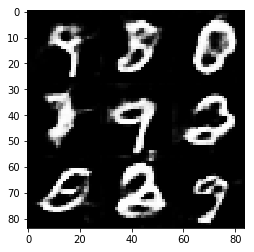

Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 1.6416
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 1.0193... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.8132... Generator Loss: 0.2511
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 1.7689
Epoch 2/2... Discriminator Loss: 1.6815... Generator Loss: 0.3017
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 1.8426
Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.8164


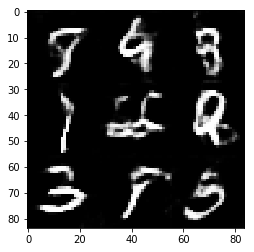

Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.8283
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.4632
Epoch 2/2... Discriminator Loss: 1.5017... Generator Loss: 0.3848
Epoch 2/2... Discriminator Loss: 1.8297... Generator Loss: 0.2359
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.4561
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 1.4861... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.7397


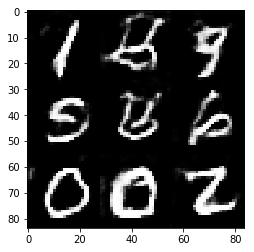

Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.8716
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 2.0298... Generator Loss: 0.1898
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.4824
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.4319
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.6463


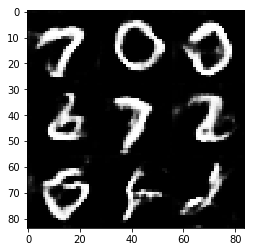

Epoch 2/2... Discriminator Loss: 1.7393... Generator Loss: 0.2565
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.6132
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.4513
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 1.4044
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 2.2456
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.9018... Generator Loss: 0.2578


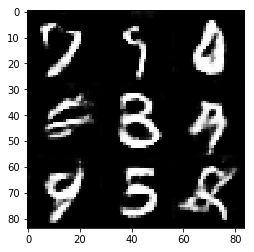

Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.4423
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 1.5726... Generator Loss: 0.3455
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.0283


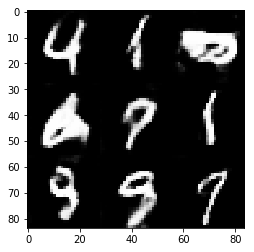

Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.0511
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 1.7426
Epoch 2/2... Discriminator Loss: 0.7211... Generator Loss: 1.3680
Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 1.5291
Epoch 2/2... Discriminator Loss: 2.1488... Generator Loss: 0.1739
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.4039
Epoch 2/2... Discriminator Loss: 1.1176... Generator Loss: 1.5232


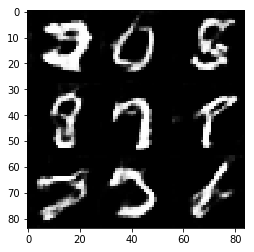

Epoch 2/2... Discriminator Loss: 0.9761... Generator Loss: 0.7045
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 0.6511
Epoch 2/2... Discriminator Loss: 1.8657... Generator Loss: 0.2023
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 1.7134... Generator Loss: 0.3095
Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 1.8613
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.3173
Epoch 2/2... Discriminator Loss: 1.9453... Generator Loss: 0.2246
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 2.1775


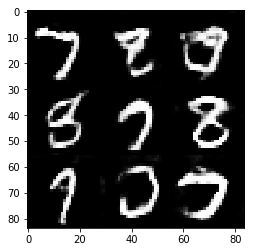

Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 0.7402
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.3834
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 0.9494
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.4008
Epoch 2/2... Discriminator Loss: 1.6984... Generator Loss: 0.2715
Epoch 2/2... Discriminator Loss: 0.9193... Generator Loss: 1.8003
Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.3669


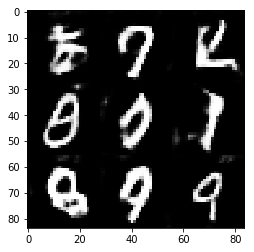

Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 1.6557
Epoch 2/2... Discriminator Loss: 0.6731... Generator Loss: 1.2208
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.7975
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.8441
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 1.9669
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 1.3961
Epoch 2/2... Discriminator Loss: 1.0454... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 0.4354
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 0.3632


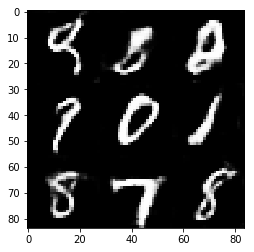

Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 2.0874
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 1.6530... Generator Loss: 0.3919
Epoch 2/2... Discriminator Loss: 1.8717... Generator Loss: 0.2083
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 0.8289
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.0592
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.3909
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.4540
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.1771


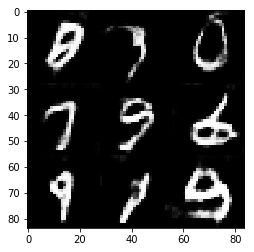

Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 0.6953... Generator Loss: 1.1629
Epoch 2/2... Discriminator Loss: 1.4333... Generator Loss: 0.4004
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 2.2950
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 1.9663... Generator Loss: 0.2093
Epoch 2/2... Discriminator Loss: 1.7520... Generator Loss: 3.0066
Epoch 2/2... Discriminator Loss: 1.1485... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 1.2628


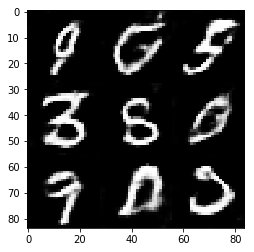

Epoch 2/2... Discriminator Loss: 1.2122... Generator Loss: 0.5483
Epoch 2/2... Discriminator Loss: 0.9358... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 1.9940
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 2.9301
Epoch 2/2... Discriminator Loss: 1.6107... Generator Loss: 0.3356
Epoch 2/2... Discriminator Loss: 0.7604... Generator Loss: 1.2035
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 1.2889
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.4642
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.4504
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.8255


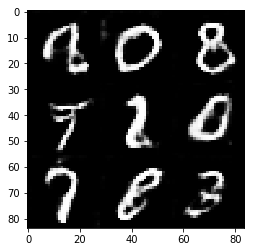

Epoch 2/2... Discriminator Loss: 1.9526... Generator Loss: 0.2039
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.7039... Generator Loss: 2.3332
Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 1.5042
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.8672
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.6037... Generator Loss: 0.3706
Epoch 2/2... Discriminator Loss: 1.7503... Generator Loss: 0.2880
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.4788


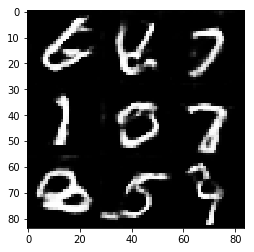

Epoch 2/2... Discriminator Loss: 1.5683... Generator Loss: 0.2979
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 1.4403
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.3965
Epoch 2/2... Discriminator Loss: 1.2278... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 1.9564
Epoch 2/2... Discriminator Loss: 1.0741... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 1.0583
Epoch 2/2... Discriminator Loss: 0.9239... Generator Loss: 1.8458
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.7475
Epoch 2/2... Discriminator Loss: 0.5610... Generator Loss: 1.7710


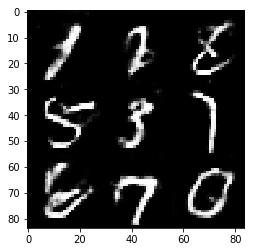

Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.5582
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.6279
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 2.8038
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 1.5536... Generator Loss: 0.3147
Epoch 2/2... Discriminator Loss: 2.0634... Generator Loss: 0.2061
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 0.7540
Epoch 2/2... Discriminator Loss: 1.6934... Generator Loss: 0.2935


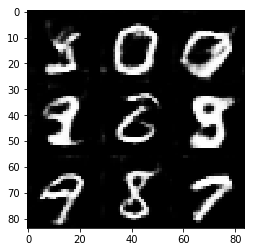

Epoch 2/2... Discriminator Loss: 0.8411... Generator Loss: 1.6841
Epoch 2/2... Discriminator Loss: 2.2536... Generator Loss: 0.1323
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.0653
Epoch 2/2... Discriminator Loss: 2.1575... Generator Loss: 0.2040
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.5494
Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.5291
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 0.8244... Generator Loss: 2.1781


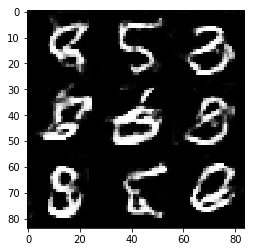

Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.1421
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 0.6958... Generator Loss: 1.5941
Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 1.0378
Epoch 2/2... Discriminator Loss: 1.6665... Generator Loss: 0.3504
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 2.4324
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 2.1904
Epoch 2/2... Discriminator Loss: 0.9601... Generator Loss: 0.9548
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.9384


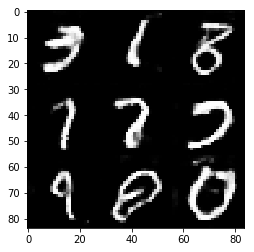

Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 1.7257
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 3.4710


In [99]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6278... Generator Loss: 2.1475
Epoch 1/1... Discriminator Loss: 3.3631... Generator Loss: 1.8474
Epoch 1/1... Discriminator Loss: 2.5514... Generator Loss: 2.0086
Epoch 1/1... Discriminator Loss: 2.4960... Generator Loss: 2.4077
Epoch 1/1... Discriminator Loss: 2.0275... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 5.1405... Generator Loss: 7.3416
Epoch 1/1... Discriminator Loss: 2.1693... Generator Loss: 0.2188
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 2.4814
Epoch 1/1... Discriminator Loss: 2.3224... Generator Loss: 0.1583


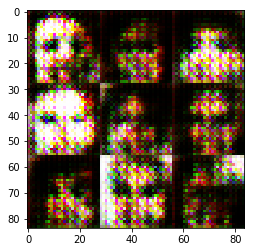

Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 7.3458
Epoch 1/1... Discriminator Loss: 0.3676... Generator Loss: 2.0729
Epoch 1/1... Discriminator Loss: 3.0218... Generator Loss: 0.1058
Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 2.4479
Epoch 1/1... Discriminator Loss: 0.0226... Generator Loss: 4.8266
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 2.5445... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.7328


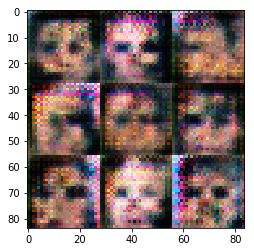

Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 2.9290... Generator Loss: 0.0977
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 1.1997
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.4349


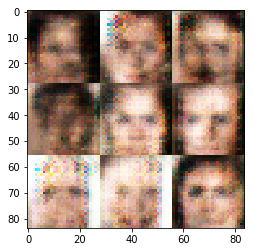

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.8227... Generator Loss: 0.3243
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.9827


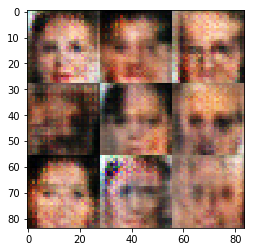

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7689


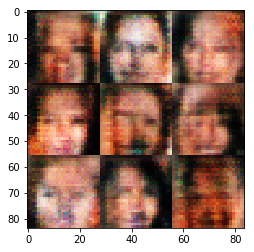

Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.5014
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4546


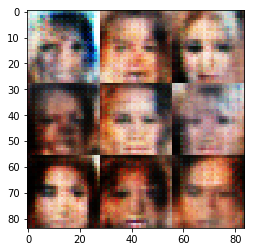

Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6866


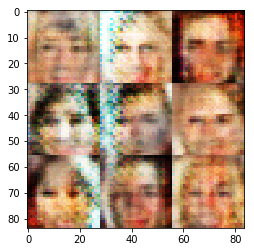

Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6987


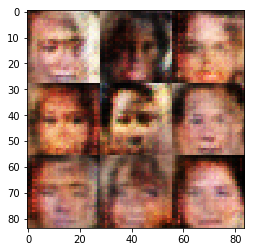

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.3343
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.5311
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.3261
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.6481


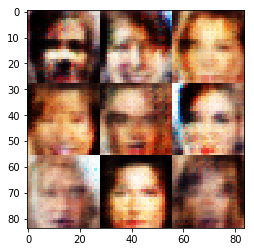

Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 1.4805
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.7759... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6968


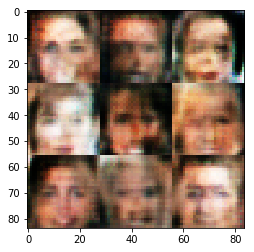

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6599


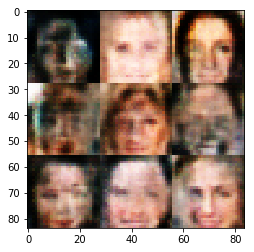

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8426


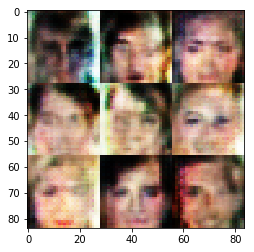

Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 2.0612... Generator Loss: 0.2021
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6279


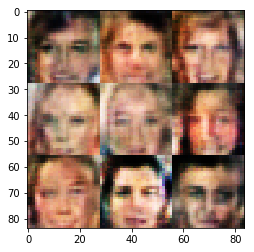

Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9669


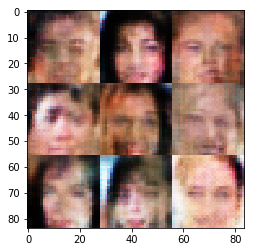

Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.7101... Generator Loss: 0.2845
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6681


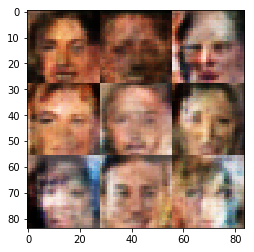

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.3941


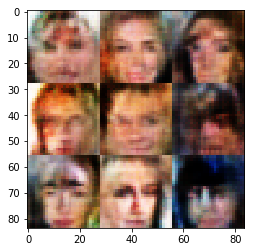

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.4873
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.5988


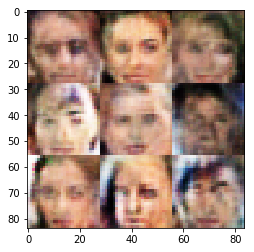

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.4273
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.8522


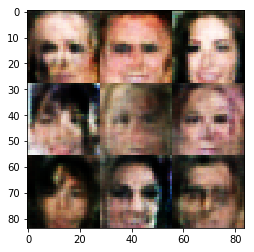

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6586


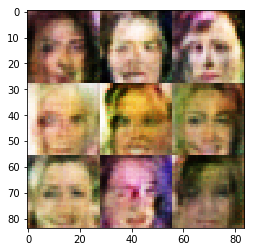

Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.3893
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.4079
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.3210


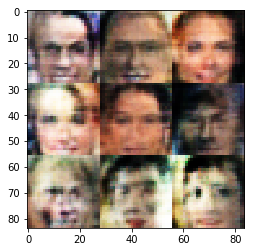

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7743


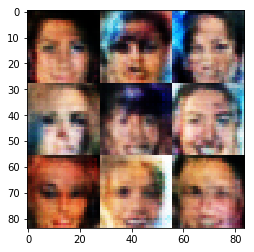

Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 2.4377... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7082


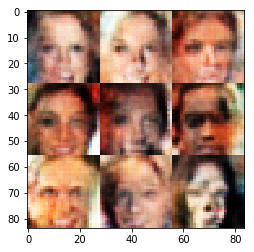

Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.3169
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6441


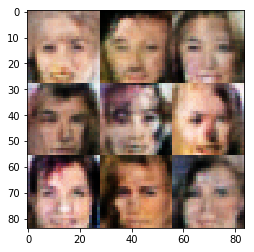

Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.8489... Generator Loss: 0.2261
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6022


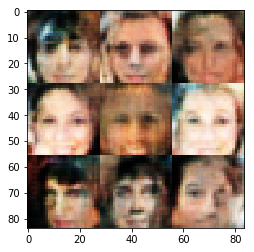

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6984


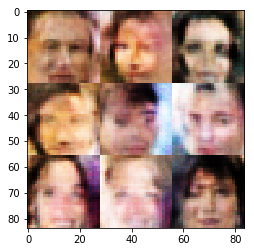

Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7169


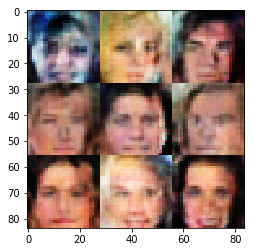

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7200


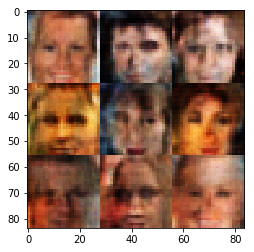

Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7887


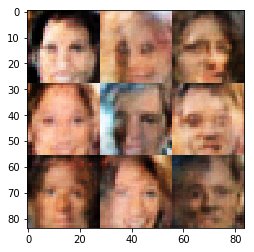

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.4295
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5913


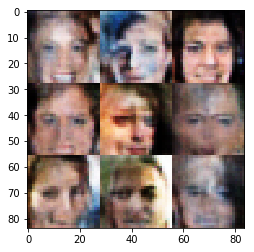

KeyboardInterrupt: 

In [100]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.